In [1]:
import pandas as pd
import os
import glob

# ==========================================
# 1. 批量读取分城市文件夹中的 Excel 文件
# ==========================================
folder_path = ".\\zlzp"  # 主文件夹路径
city_folders = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

print(f"找到城市文件夹：{city_folders}")

df_list = []

# 遍历每个城市文件夹
for city in city_folders:
    city_path = os.path.join(folder_path, city)
    # 获取该城市文件夹下所有 .xlsx 文件
    excel_files = glob.glob(os.path.join(city_path, "*.xlsx"))
    
    print(f"正在读取 {city}：找到 {len(excel_files)} 个文件")
    
    for filename in excel_files:
        try:
            temp_df = pd.read_excel(filename)
            # 添加城市列，方便后续分析
            temp_df['source_city'] = city
            df_list.append(temp_df)
            print(f"  ✓ {os.path.basename(filename)}")
        except Exception as e:
            print(f"  ✗ 读取 {filename} 失败: {e}")

# 2. 合并成一个大表
if len(df_list) > 0:
    df_zl = pd.concat(df_list, ignore_index=True)
    print(f"\n成功合并 {len(df_list)} 个文件，共 {len(df_zl)} 条数据")
    print(f"包含城市：{df_zl['source_city'].unique()}")
else:
    print("未找到任何 Excel 文件，请检查路径")

找到城市文件夹：['上海', '北京', '南京', '广州', '杭州', '深圳']
正在读取 上海：找到 12 个文件
  ✓ 产品_上海.xlsx
  ✓ 保险_上海.xlsx
  ✓ 咨询_上海.xlsx
  ✓ 商业分析_上海.xlsx
  ✓ 基金_上海.xlsx
  ✓ 投行_上海.xlsx
  ✓ 数据分析_上海.xlsx
  ✓ 证券_上海.xlsx
  ✓ 财务_上海.xlsx
  ✓ 运营_上海.xlsx
  ✓ 量化_上海.xlsx
  ✓ 银行_上海.xlsx
正在读取 北京：找到 12 个文件
  ✓ 产品_北京.xlsx
  ✓ 保险_北京.xlsx
  ✓ 咨询_北京.xlsx
  ✓ 商业分析_北京.xlsx
  ✓ 基金_北京.xlsx
  ✓ 投行_北京.xlsx
  ✓ 数据分析_北京.xlsx
  ✓ 证券_北京.xlsx
  ✓ 财务_北京.xlsx
  ✓ 运营_北京.xlsx
  ✓ 量化_北京.xlsx
  ✓ 银行_北京.xlsx
正在读取 南京：找到 5 个文件
  ✓ 产品_南京.xlsx
  ✓ 基金_南京.xlsx
  ✓ 财务_南京.xlsx
  ✓ 运营_南京.xlsx
  ✓ 银行_南京.xlsx
正在读取 广州：找到 10 个文件
  ✓ 产品_广州.xlsx
  ✓ 保险_广州.xlsx
  ✓ 咨询_广州.xlsx
  ✓ 基金_广州.xlsx
  ✓ 投行_广州.xlsx
  ✓ 数据分析_广州.xlsx
  ✓ 证券_广州.xlsx
  ✓ 财务_广州.xlsx
  ✓ 运营_广州.xlsx
  ✓ 银行_广州.xlsx
正在读取 杭州：找到 5 个文件
  ✓ 产品_杭州.xlsx
  ✓ 保险_杭州.xlsx
  ✓ 基金_杭州.xlsx
  ✓ 财务_杭州.xlsx
  ✓ 银行_杭州.xlsx
正在读取 深圳：找到 11 个文件
  ✓ 产品_深圳.xlsx
  ✓ 保险_深圳.xlsx
  ✓ 咨询_深圳.xlsx
  ✓ 基金_深圳.xlsx
  ✓ 投行_深圳.xlsx
  ✓ 数据分析_深圳.xlsx
  ✓ 证券_深圳.xlsx
  ✓ 财务_深圳.xlsx
  ✓ 运营_深圳.xlsx
  ✓ 量化_深圳.xlsx
  ✓ 银行_深圳.xlsx

成功合并 55 个文件

In [2]:
import re

# ==========================================
# 2. 数据清洗函数
# ==========================================

# --- A. 洗薪资 (C列: 1.2-2.4万 -> 平均值 18.0) ---
def clean_zl_salary(s):
    s = str(s)
    if '面议' in s or pd.isna(s):
        return None
    
    # 统一单位：如果是“万”，乘10；如果是原数字（8000），除1000
    try:
        # 提取数字部分
        nums = re.findall(r'\d+\.?\d*', s)
        if len(nums) < 2: return None
        low, high = float(nums[0]), float(nums[1])
        
        # 判断单位
        if '万' in s:
            return (low + high) / 2 * 10  # 1.2万 -> 12k
        elif '千' in s:
            return (low + high) / 2       # 8千 -> 8k
        else:
            # 假设是原始数值 (如 8000-12000)
            if low > 100: # 简单的阈值判断
                return (low + high) / 2 / 1000
            else:
                return (low + high) / 2 # 已经是k为单位了
    except:
        return None

# --- B. 洗位置 (E列: 深圳·龙岗 -> 深圳) ---
def get_city(s):
    if pd.isna(s): return '未知'
    # 截图显示是用 "·" 分隔的，取第一个就是城市
    return s.split('·')[0]

# --- C. 洗要求 (D列: 1-3年,大专 -> 分开) ---
def split_req(s, type_='edu'):
    # 假设格式是 "经验,学历" 或者 "学历,经验"
    # 我们用关键词匹配更稳妥
    s = str(s)
    edus = ['大专', '本科', '硕士', '博士', '学历不限', '中专', '高中']
    for e in edus:
        if e in s and type_ == 'edu':
            return e
            
    # 如果是找经验
    if type_ == 'exp':
        # 把学历剔除，剩下的就是经验
        for e in edus:
            s = s.replace(e, '').replace(',', '').replace('，', '')
        return s.strip()
    return '未知'

# --- D. 岗位分类 (核心需求) ---
def categorize_job_zl(title):
    t = str(title).lower()
    # 按照你的要求分类
    if any(x in t for x in ['保险', '核保', '理赔', '精算', '查勘']): return '保险'
    if any(x in t for x in ['财务', '会计', '审计', '出纳', '税务']): return '财务'
    if any(x in t for x in ['产品', '策划']): return '产品'
    if any(x in t for x in ['基金']): return '基金'
    if any(x in t for x in ['量化', '算法', '策略']): return '量化'
    if any(x in t for x in ['证券', '股票', '交易员']): return '证券'
    if any(x in t for x in ['银行', '柜员', '信贷']): return '银行'
    if any(x in t for x in ['投行', '保荐', '承销']): return '投行'
    if any(x in t for x in ['商业分析', '数据分析', 'bi', 'ba', '分析师']): return '商业/数据分析'
    if any(x in t for x in ['运营', '新媒体', '电商']): return '运营'
    if any(x in t for x in ['咨询', '顾问', '猎头']): return '咨询'
    return '其他'

# ==========================================
# 3. 应用清洗
# ==========================================
# 假设你的 DataFrame 叫 df_zl
# 请确保列名和你截图里的一样，如果不一样请修改下面的中括号内容

df_zl['avg_salary'] = df_zl['岗位薪资'].apply(clean_zl_salary)
df_zl['city'] = df_zl['公司位置'].apply(get_city)
df_zl['job_type'] = df_zl['岗位名称'].apply(categorize_job_zl)
df_zl['education'] = df_zl['岗位要求'].apply(lambda x: split_req(x, 'edu'))

# 剔除无法计算薪资的行
df_clean = df_zl.dropna(subset=['avg_salary'])
print("清洗完成！")

清洗完成！


二次清洗完成！剩余有效数据：21906 条


C:\Users\ffq73\AppData\Local\Temp\ipykernel_85328\2660945242.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_salary.index, y=city_salary.values, palette='viridis')


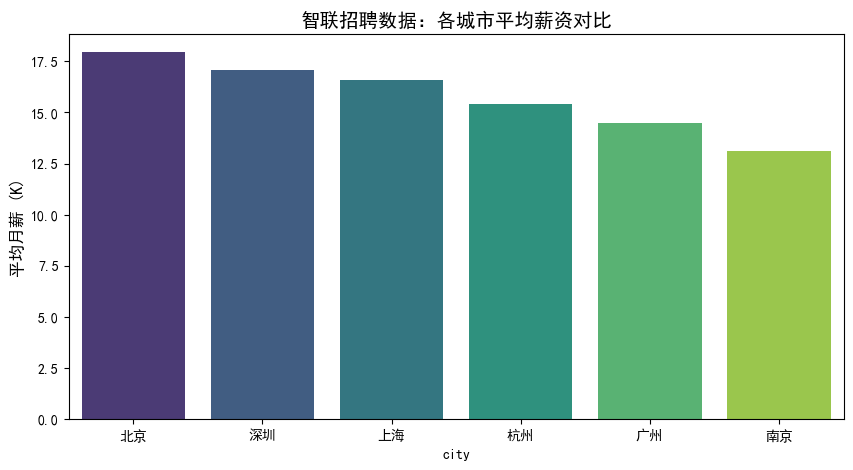

C:\Users\ffq73\AppData\Local\Temp\ipykernel_85328\2660945242.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=job_salary.index, y=job_salary.values, palette='magma')


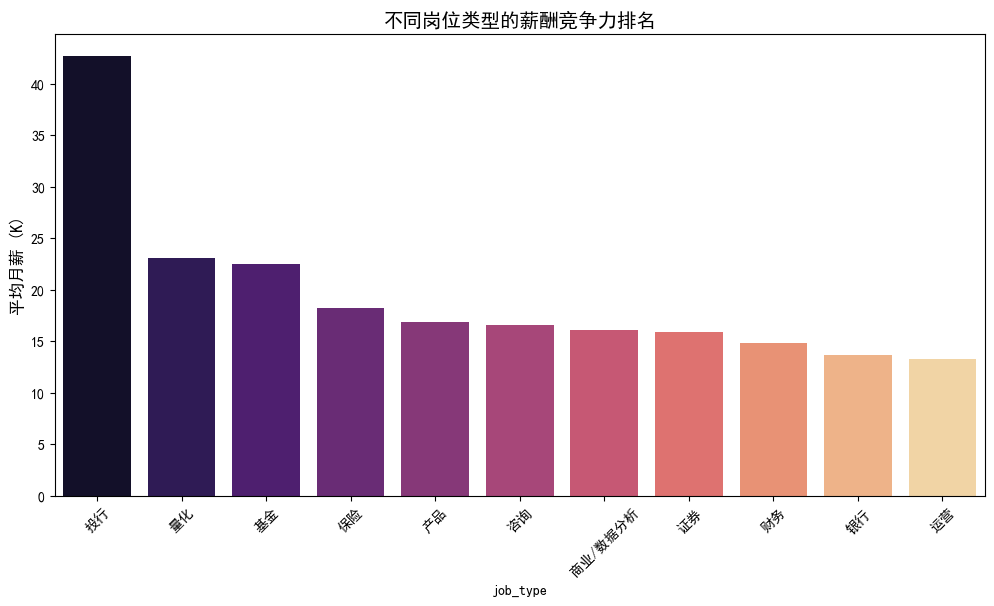

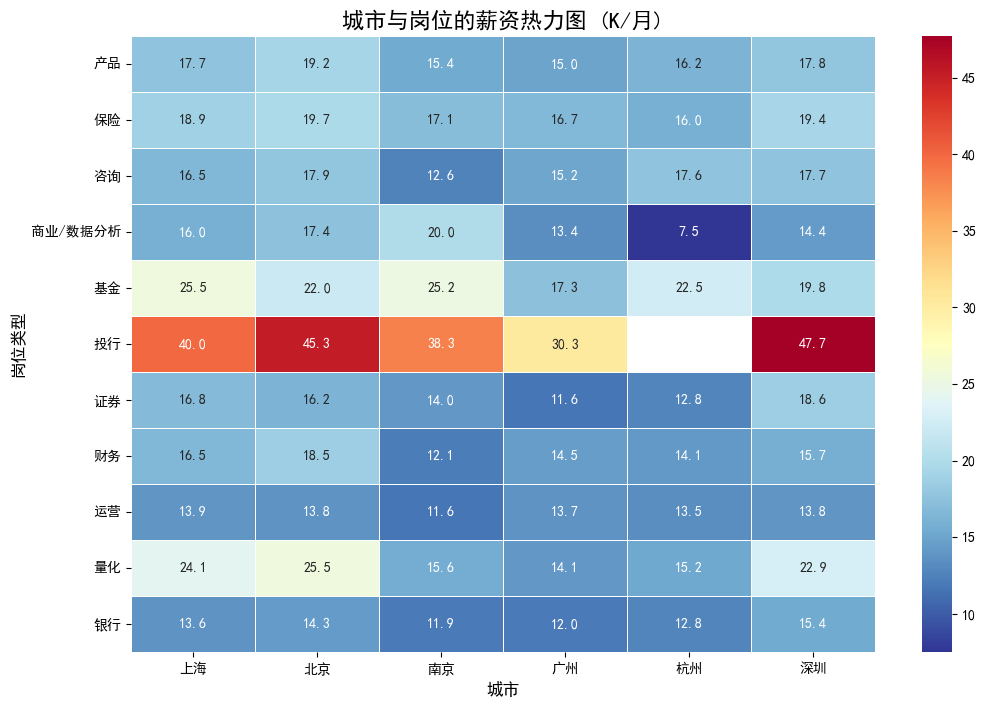

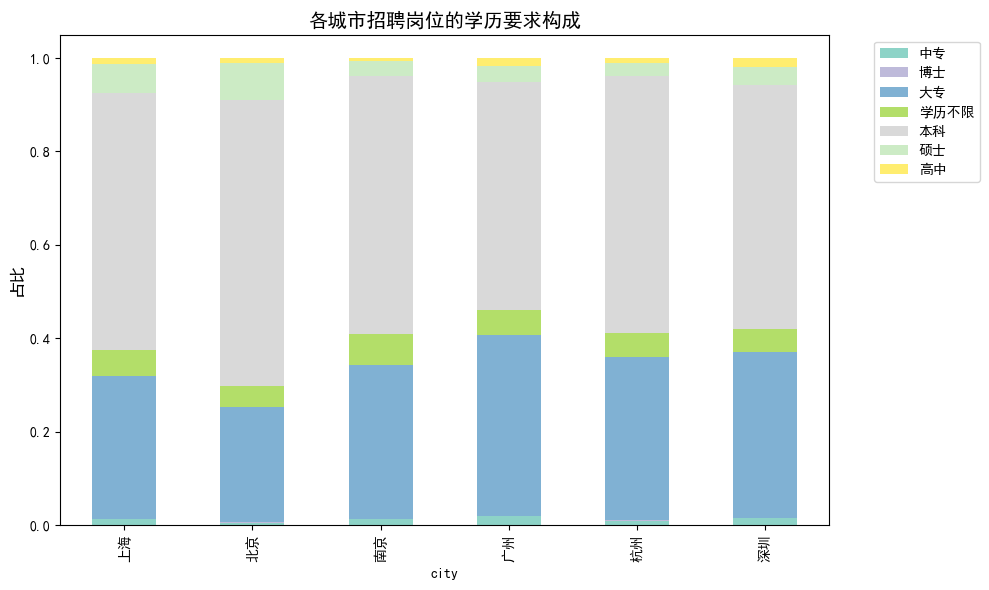

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# ==========================================
# 0. 画图前的终极去噪 (剔除 "暂无" / "未知")
# ==========================================

# 1. 定义你要剔除的垃圾词列表
dirty_words = ['暂无', '未知', 'None', '其他', '不限']

# 2. 清洗城市列 (剔除包含垃圾词的城市)
# 逻辑：保留那些 城市名 不在垃圾列表里的行
df_clean = df_clean[~df_clean['city'].isin(dirty_words)]

# 3. 清洗学历列
df_clean = df_clean[~df_clean['education'].isin(dirty_words)]

# 4. 清洗岗位类型 (如果你不想看 "其他" 类岗位，也可以在这里删掉)
df_clean = df_clean[df_clean['job_type'] != '其他']

# 5. 再次确认有没有空值
df_clean = df_clean.dropna(subset=['city', 'education', 'job_type'])

print(f"二次清洗完成！剩余有效数据：{len(df_clean)} 条")

# -------------------------------------------------------
# (下面接你原本的画图代码 plt.figure... 那些)
# -------------------------------------------------------
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 图1：各城市岗位平均薪资对比 (Bar Chart)
# ==========================================
city_salary = df_clean.groupby('city')['avg_salary'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=city_salary.index, y=city_salary.values, palette='viridis')
plt.title('智联招聘数据：各城市平均薪资对比', fontsize=14)
plt.ylabel('平均月薪 (K)', fontsize=12)
plt.show()

# ==========================================
# 图2：不同岗位类型的薪资排名 (Bar Chart)
# ==========================================
# 过滤掉 "其他" 类，只看你关心的核心岗位
core_jobs = df_clean[df_clean['job_type'] != '其他']
job_salary = core_jobs.groupby('job_type')['avg_salary'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=job_salary.index, y=job_salary.values, palette='magma')
plt.title('不同岗位类型的薪酬竞争力排名', fontsize=14)
plt.ylabel('平均月薪 (K)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# ==========================================
# 图3：城市 x 岗位 热力图 (Heatmap) —— 核心分析图
# ==========================================
# 逻辑：横坐标是城市，纵坐标是岗位，颜色深浅代表工资高低
# 这张图能一眼看出：想做“量化”去哪个城市最赚钱？
pivot_data = core_jobs.pivot_table(index='job_type', columns='city', values='avg_salary', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, fmt=".1f", cmap='RdYlBu_r', linewidths=0.5)
plt.title('城市与岗位的薪资热力图 (K/月)', fontsize=16)
plt.xlabel('城市', fontsize=12)
plt.ylabel('岗位类型', fontsize=12)
plt.show()

# ==========================================
# 图4：各城市对学历的要求分布 (Stacked Bar)
# ==========================================
# 看看哪个城市最卷学历？
edu_city = pd.crosstab(df_clean['city'], df_clean['education'])
# 归一化为百分比
edu_city_pct = edu_city.div(edu_city.sum(1), axis=0)

edu_city_pct.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')
plt.title('各城市招聘岗位的学历要求构成', fontsize=14)
plt.ylabel('占比', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\xixif\AppData\Local\Temp\ipykernel_42680\1134802416.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlBu_r')


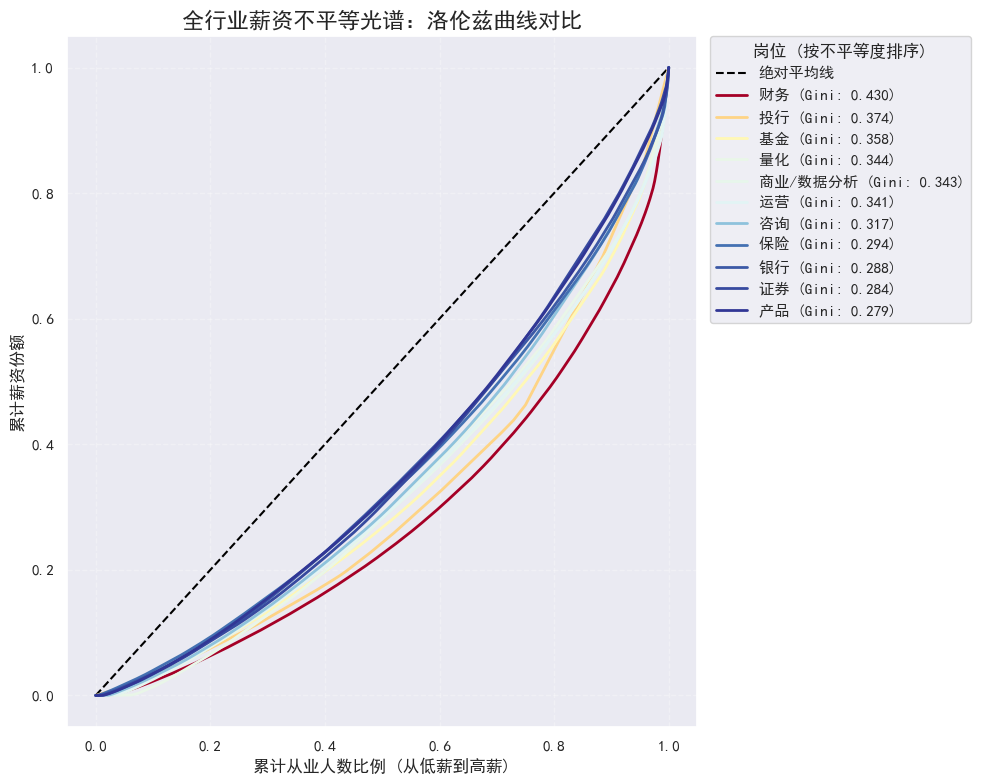

------ 岗位薪资不平等度排名 (从高到低) ------
         岗位      Gini
0        财务  0.430243
1        投行  0.373583
2        基金  0.357981
3        量化  0.343889
4   商业/数据分析  0.343291
5        运营  0.340737
6        咨询  0.316674
7        保险  0.293940
8        银行  0.287559
9        证券  0.284330
10       产品  0.279225


In [4]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# ==========================================
# 【关键】设置中文字体（必须在导入后立即设置）
# ==========================================
# Windows 系统
matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 或者如果用 seaborn，也需要设置
sns.set_style("whitegrid")
sns.set(font='SimHei')  # 让 seaborn 的文字也用中文字体

# 设置图表尺寸和分辨率
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
# ==========================================
# 1. 准备数据：计算所有岗位的基尼系数
# ==========================================
# 假设 df_clean 是你清洗好的智联数据
job_types = df_clean['job_type'].unique()
gini_data = []

def calculate_gini(x):
    # 标准基尼系数计算函数
    x = np.array(x, dtype=np.float64)
    if np.any(x < 0): return 0
    if len(x) == 0: return 0
    sorted_x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(sorted_x, dtype=np.float64)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

# 遍历计算
for job in job_types:
    if job == '其他': continue # 跳过“其他”类
    salaries = df_clean[df_clean['job_type'] == job]['avg_salary'].values
    if len(salaries) > 10: # 样本太少不画，没意义
        g = calculate_gini(salaries)
        gini_data.append({'岗位': job, 'Gini': g})

# 转为 DataFrame 并排序 (关键！必须排序才能做渐变色)
gini_df = pd.DataFrame(gini_data).sort_values('Gini', ascending=False)

# ==========================================
# 2. 绘制全岗位洛伦兹曲线
# ==========================================
plt.figure(figsize=(10, 8))

# 画对角线 (绝对平均线)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=1.5, label='绝对平均线')

# 设置颜色映射 (从红到蓝：RdYlBu)
# 也就是：基尼系数越高越红，越低越蓝
norm = plt.Normalize(gini_df['Gini'].min(), gini_df['Gini'].max())
cmap = cm.get_cmap('RdYlBu_r') 

# 循环画每一条线
for idx, row in gini_df.iterrows():
    job_name = row['岗位']
    gini_val = row['Gini']
    
    # 提取该岗位的薪资数据
    salaries = np.sort(df_clean[df_clean['job_type'] == job_name]['avg_salary'].values)
    
    # 计算洛伦兹曲线坐标
    # Y轴：累计薪资占比
    y = np.cumsum(salaries) / salaries.sum()
    y = np.insert(y, 0, 0)
    # X轴：累计人数占比
    x = np.linspace(0, 1, len(y))
    
    # 根据基尼系数获取颜色
    color = cmap(norm(gini_val))
    
    # 画线 (linewidth设细一点，防止重叠太严重)
    plt.plot(x, y, color=color, linewidth=2, label=f"{job_name} (Gini: {gini_val:.3f})")

# ==========================================
# 3. 美化图表
# ==========================================
plt.title('全行业薪资不平等光谱：洛伦兹曲线对比', fontsize=16)
plt.xlabel('累计从业人数比例 (从低薪到高薪)', fontsize=12)
plt.ylabel('累计薪资份额', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

# 关键：把图例放在图的外面，否则会挡住曲线
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title="岗位 (按不平等度排序)")

# 调整布局防止切边
plt.tight_layout()
plt.show()

# 打印一下排名表，方便你写报告
print("------ 岗位薪资不平等度排名 (从高到低) ------")
print(gini_df.reset_index(drop=True))